In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose( [transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [3]:
train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

Files already downloaded and verified


In [4]:
trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)


In [5]:
test = torchvision.datasets.CIFAR10('./data',
    download=True,
    train=False,
    transform=transform)

testset = torch.utils.data.DataLoader(test, batch_size=4,
                                        shuffle=False, num_workers=2)

Files already downloaded and verified


In [6]:
class RBF(nn.Module):

    def __init__(self,input_dim,output_dim,hidden_dim):
        super().__init__()
        self.first_layer = nn.Linear(input_dim,hidden_dim)
        self.hidden_layer = nn.Linear(hidden_dim,output_dim)
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.s = 0.02
        self.centers = nn.Parameter(torch.randn(input_dim,hidden_dim))

    def formula(self,x,y):
        return torch.exp(-self.s * (x.unsqueeze(1) - y).pow(2).sum(dim=1))

    def forward(self,x):
        x = x.view(-1, 3072)
        out1 = self.first_layer(x)
        out3 = self.hidden_layer(out1)
        a = self.formula(out3, self.centers)
        return a

In [7]:
model = RBF(input_dim=3*32*32,output_dim=10,hidden_dim=10)
print(model)

RBF(
  (first_layer): Linear(in_features=3072, out_features=10, bias=True)
  (hidden_layer): Linear(in_features=10, out_features=10, bias=True)
)


In [8]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(1): 
    for data in trainset:  
        X, y = data  
        model.zero_grad()  
        output = model(X.view(-1,3*32*32)) 
        loss = loss_function(output, y)  
        loss.backward()  
        optimizer.step() 

In [9]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [10]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("runs/cifar10")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


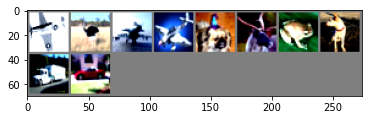

In [16]:
dataiter = iter(trainset)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=False)
writer.add_image('cifar10_images', img_grid)

In [13]:
writer.add_graph(model, images)
writer.close()